# Testing for ideas

In [14]:
import numpy as np
from skimage.io import imread, imsave
from skimage.exposure import rescale_intensity
from skimage.draw import disk, circle_perimeter
from skimage.color import gray2rgb
import matplotlib.pyplot as plt
import os
import cv2 as cv

%matplotlib inline

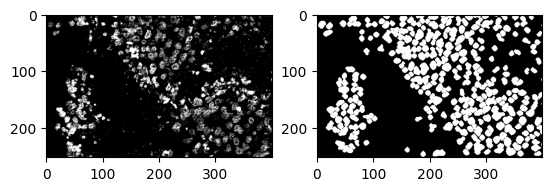

In [2]:
ROOT = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(ROOT, 'Data')

image_dir = os.path.join(DATA_DIR, 'raw')
mask_dir = os.path.join(DATA_DIR, 'mask')
# read in raw cell image and rescale its intensity
nuc_img = plt.imread(os.path.join(image_dir, 'nuclei.tiff'))
nuc_img = rescale_intensity(nuc_img, (100, 400)) # need to manually set the intensity range
nuc_img = nuc_img[600:nuc_img.shape[0], 0:400]
# read in mask and rescale its intensity
nuc_mask = plt.imread(os.path.join(mask_dir, 'mask.tiff'))
nuc_mask = rescale_intensity(nuc_mask, (100, 400)) # need to manually set the intensity range
nuc_mask = nuc_mask[600:nuc_mask.shape[0], 0:400]

# uncomment to save cropped cell image and mask
# imsave(os.path.join(image_dir, "cropped_cell_im.png"), nuc_img)
# imsave(os.path.join(mask_dir, "cropped_cell_mask.png"), nuc_mask)

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(nuc_img, cmap='gray')
axes[1].imshow(nuc_mask, cmap='gray')


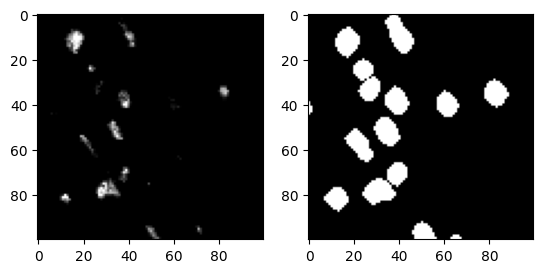

In [ ]:
# read in raw cell image and rescale its intensity
nuc_img = plt.imread(os.path.join(image_dir, 'test_easy_img.tiff'))
crop_shape = np.asanyarray([500,600,300,400])
nuc_img = rescale_intensity(nuc_img, (100, 400)) # need to manually set the intensity range
nuc_img = nuc_img[crop_shape[0]:crop_shape[1], crop_shape[2]:crop_shape[3]]
# read in mask and rescale its intensity
nuc_mask = plt.imread(os.path.join(mask_dir, 'test_easy_mask.tiff'))
nuc_mask = rescale_intensity(nuc_mask, (100, 400)) # need to manually set the intensity range
nuc_mask = nuc_mask[crop_shape[0]:crop_shape[1], crop_shape[2]:crop_shape[3]]

# uncomment to save cropped cell image and mask
imsave(os.path.join(image_dir, "test_easy_img.png"), nuc_img)
imsave(os.path.join(mask_dir, "test_easy_mask.png"), nuc_mask)

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(nuc_img, cmap='gray')
axes[1].imshow(nuc_mask, cmap='gray')

## Evolve curve around an object

In [197]:
# Initialize a guesss of the contour
def initialize(img):
    '''
    Distance transforming image into a family of level sets psi = +/-d
    The psi = 0 level always yields the moving front of a shape, aka the curve.
    '''
    if len(img.shape) > 2:
        img = np.clip(img, 0, 255)
        img_invert = 255 - img # this step will change boundaries to 0
        img = img.astype('uint8')
        img_invert = img_invert.astype('uint8')
        # conver to single-channgle gray-scale image
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 
        img_invert = cv.cvtColor(img_invert, cv.COLOR_BGR2GRAY)
    # distance transform the image with a 3 x 3 kernel. 
    dist_img = cv.distanceTransform(img, cv.DIST_L2, 3) 
    # img_invert[dist_img==dist_img.max()] = 255 # (omitted because we only need distance to the boundary) need to restore the boundaries
    dist_img_invert = cv.distanceTransform(img_invert, cv.DIST_L2, 3)
    psi = dist_img + dist_img_invert 
    dist_img = -1 * dist_img # the distances inside the boundaries are negative
    psi = dist_img + dist_img_invert # now the boundaries are fixed and zero
    psi = cv.GaussianBlur(psi, (3,3), sigmaX=1, borderType=cv.BORDER_DEFAULT)
    return psi

def draw_curve(psi, axis, colors='red', levels=[0]):
    '''
    Draw curve U on an image. By default, it is drawn in the red channel
    '''
    # curve at zero-crossing
    # draw levels with equal spacings
    # find the curve that cross zero level
    X = np.arange(0, psi.shape[1])
    Y = np.arange(0, psi.shape[0])
    xs, ys = np.meshgrid(X, Y, sparse=True)
    Z = psi[ys, xs]
    return axis.contour(X, Y, Z, levels=levels, colors=colors)

def pad(a):
    '''
    Pad the edge of an array a
    '''
    if a.shape[0] < 1 or a.shape[1] < 1:
        print('Image has invalid shape: expected sizes of dimensions to be greater than 1.')
    a = np.hstack((a[:,0][:, np.newaxis], a))
    a = np.hstack((a, a[:,a.shape[1]-1][:, np.newaxis]))
    a = np.vstack((a[0,:][np.newaxis, :], a))
    a = np.vstack((a, a[a.shape[0]-1,:][np.newaxis, :]))
    return a

def central_difference(psi):
    '''
    Compute central differences along x-axis, y-axis, and between x,y-axes
    '''
    # expanding psi to prevent shrinking in size after taking differences
    psi = pad(psi)
    m, n = psi.shape
    # print(m,n)
    dx = 0.5 * (psi[2:m, 1:n-1]-psi[0:m-2, 1:n-1])
    dy = 0.5 * (psi[1:m-1, 2:n]-psi[1:m-1, 0:n-2])
    dxx = (psi[2:m, 1:n-1] - psi[1:m-1, 1:n-1]) - (psi[1:m-1, 1:n-1] - psi[0:m-2, 1:n-1])
    dyy = (psi[1:m-1, 2:n] - psi[1:m-1, 1:n-1]) - (psi[1:m-1, 1:n-1] - psi[1:m-1, 0:n-2])
    dxy = 0.25 * ((psi[2:m, 2:n] - psi[0:m-2, 2:n]) - (psi[2:m, 0:n-2] - psi[0:m-2, 0:n-2]))
    return dx, dy, dxx, dyy, dxy

def finite_difference(psi, F, dt):
    '''
    Compute finite differences along the t direction at a give point psi(i,j)
    '''
    psi_right = psi[:] + dt * F
    right_diff = (psi_right - psi[:])
    psi_left = psi[:] - dt * F
    left_diff = (psi[:] - psi_left)
    return left_diff, right_diff

def finite_gradient(psi, F, dt):
    '''
    Compute gradient on the right and on the left at point psi(i,j) by using a finite difference scheme
    '''
    left_diff, right_diff = finite_difference(psi, F, dt)
    forward_grad = np.power(np.max(0, left_diff), 2) + np.power(np.min(0, right_diff), 2)
    backward_grad = np.power(np.max(0, right_diff), 2) + np.power(np.min(0, left_diff), 2)
    return forward_grad, backward_grad

def get_stopping_term(img, c=1):
    '''
    c contronls how penalizing the edges should be
    '''
    # print(img.shape)
    if len(img.shape) > 2:
        img = img.astype('uint8')
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    img = pad(img)
    m,n = img.shape
    dx = 0.5 * (img[2:m, 1:n-1]-img[0:m-2, 1:n-1])
    dy = 0.5 * (img[1:m-1, 2:n]-img[1:m-1, 0:n-2])
    grad_mag = np.sqrt(dx**2 + dy**2)
    # return np.exp(-1*(grad_mag)**2 / (2*c**2)) # return the gaussian of the gradient magnitude
    return 1. / (1. + c*grad_mag)

def get_K(psi):
    dx, dy, dxx, dyy, dxy = central_difference(psi)
    K = (dxx*dy**2 - 2*dy*dx*dxy + dyy*dx**2) / (np.power(dx**2 + dy**2, 1.5) + np.finfo('float').eps)
    return K

def curve_evolution(contour, img, dt=0.1, velocity=0.5, max_iter=1000):
    '''
    Evolve the curve based on the magitude the image gradient, curvature and gradient of image
    '''
    psi = initialize(contour)
    # Adjust force according to the gradient of the image
    F = get_stopping_term(img)
    fx, fy, _, _, _ = central_difference(F) # derivative of stopping term to make curve stop at weak edges (inplicit edges)
    for i in range(max_iter):
        K = get_K(psi)
        dx, dy, _, _, _ = central_difference(psi)
        grad_mag = np.sqrt(dx**2 + dy**2)
        # forward_grad, backward_grad = finite_gradient(psi, F, dt)
        # # F(K) = F0 + F_1(K), where F0 is the advection component
        # F0 = np.where(F > 0, F, 0) * forward_grad + np.where(F < 0, F, 0) * backward_grad
        expansion = F * velocity * grad_mag
        smoothing = F * K * grad_mag
        attachment = fx*dx + fy*dy
        psi[:] = psi[:] + (dt * F * grad_mag + dt * K * grad_mag + dt*attachment)
    return psi


In [ ]:
# img = imread(os.path.join(DATA_DIR, 'example', 'test.png'))
# img = cv.GaussianBlur(img, (3,3), sigmaX=1, borderType=cv.BORDER_DEFAULT)
# fig, axs = plt.subplots(nrows=20, ncols=20, figsize=(40,40))
# axs = axs.ravel()
# for max_iter, ax in zip(range(400), axs):
#     draw_curve(curve_evolution(img, dt=0.5, max_iter=max_iter), axis=ax)

In [ ]:
# img = imread(os.path.join(DATA_DIR, 'example', 'test2.png'))
# img = cv.GaussianBlur(img, (3,3), sigmaX=1, borderType=cv.BORDER_DEFAULT)
# fig, ax = plt.subplots()
# draw_curve(curve_evolution(img, dt=0.5, max_iter=100), axis=ax)

## Constant force (constant flow)

In [ ]:
# use the 

### Initialize one big curve

In [ ]:
# read in the test image 3
img = imread(os.path.join(DATA_DIR, "example", "test3.png"))
img = cv.GaussianBlur(img, (3,3), sigmaX=1, borderType=cv.BORDER_DEFAULT)
# F = get_stopping_term(img)
# plt.imshow(F, cmap='gray')
contour_layer = np.zeros_like(img)
# initialize a small circle in each circle
center_x = 100
center_y = 100
rr, cc = disk((center_x, center_y), 15) 
contour_layer[rr, cc, :] = [255, 255, 255]

center_x = 50
center_y = 260
rr, cc = disk((center_x, center_y), 15) 
contour_layer[rr, cc, :] = [255, 255, 255]

center_x = 250
center_y = 175
rr, cc = disk((center_x, center_y), 15) 
contour_layer[rr, cc, :] = [255, 255, 255]

center_x = 200
center_y = 300
rr, cc = disk((center_x, center_y), 15) 
contour_layer[rr, cc, :] = [255, 255, 255]

# plt.imshow(img)
# plt.imshow(contour_layer)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 50))
max_iters = [100, 200, 300]
for i in range(3):
    # initalize psi
    psi = initialize(contour_layer)
    # evolve the contour with psi
    psi = curve_evolution(contour_layer, img, dt=0.2, max_iter=max_iters[i])
    axs[i].imshow(img)
    draw_curve(psi, axis=axs[i])
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    axs[i].set_xticks([])
    axs[i].set_yticks([])

### Initialize several curves

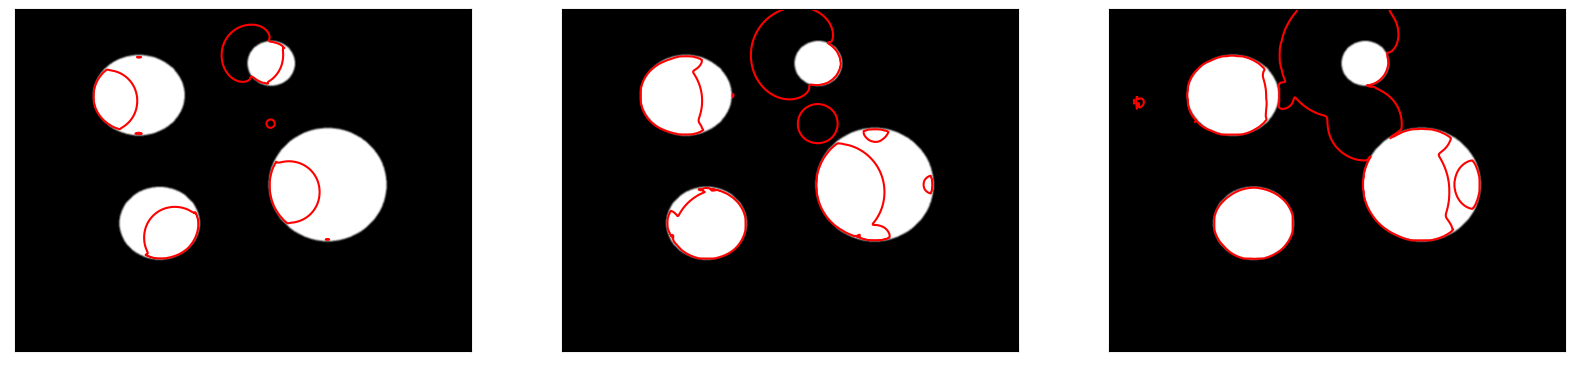

In [193]:
# read in the test image 3
img = imread(os.path.join(DATA_DIR, "example", "test3.png"))
img = cv.GaussianBlur(img, (3,3), sigmaX=1, borderType=cv.BORDER_DEFAULT)
# F = get_stopping_term(img)
# plt.imshow(F, cmap='gray')
contour_layer = np.zeros_like(img)
# initialize a small circle in each circle
center_x = 100
center_y = 100
rr, cc = disk((center_x, center_y), 15) 
contour_layer[rr, cc, :] = [255, 255, 255]

center_x = 50
center_y = 260
rr, cc = disk((center_x, center_y), 15) 
contour_layer[rr, cc, :] = [255, 255, 255]

center_x = 250
center_y = 175
rr, cc = disk((center_x, center_y), 15) 
contour_layer[rr, cc, :] = [255, 255, 255]

center_x = 200
center_y = 300
rr, cc = disk((center_x, center_y), 15) 
contour_layer[rr, cc, :] = [255, 255, 255]

# plt.imshow(img)
# plt.imshow(contour_layer)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 50))
max_iters = [100, 200, 300]
for i in range(3):
    # initalize psi
    psi = initialize(contour_layer)
    # evolve the contour with psi
    psi = curve_evolution(contour_layer, img, dt=0.2, max_iter=max_iters[i])
    axs[i].imshow(img)
    draw_curve(psi, axis=axs[i])
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    axs[i].set_xticks([])
    axs[i].set_yticks([])

## Test on cell image 

In [73]:
# read in cell image
img = imread(os.path.join(image_dir, "test_easy_img.png"))
# initialize a random shape
center_x = img.shape[0] // 2 
center_y = img.shape[1] // 2
rr, cc = disk((center_x, center_y), 50) # initialize a contour shape
contour_layer = np.zeros((img.shape[0], img.shape[1], 3))
contour_layer[rr, cc] = [255, 255, 255]

# initalize psi
psi = initialize(contour_layer)

# # evolve the contour with psi
# psi = curve_evolution(contour_layer, img, dt=0.5, max_iter=100)
# fig, ax = plt.subplots()
# psi = draw_curve(psi, axis=ax)

255
